In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pytz as tz
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_csv('../input/gowalla-checkins/Gowalla_totalCheckins.txt', sep='\t', header=None)
df.columns = ['userid','timestamp','latitude','longitude','spotid']
df.head()

,userid,timestamp,latitude,longitude,spotid
0,0,2010-10-19T23:55:27Z,30.235909,-97.795140,22847
1,0,2010-10-18T22:17:43Z,30.269103,-97.749395,420315
2,0,2010-10-17T23:42:03Z,30.255731,-97.763386,316637
3,0,2010-10-17T19:26:05Z,30.263418,-97.757597,16516
4,0,2010-10-16T18:50:42Z,30.274292,-97.740523,5535878


Let's filter the dataset to the area of New York City.

The Flickr Geo API provides us with the bounding box of the city.
[https://www.flickr.com/places/info/2459115](http://)

In [3]:
lon_min, lat_min, lon_max, lat_max = -74.2589, 40.4774, -73.7004, 40.9176
nyc_events = df[(df['longitude']>lon_min) & 
           (df['longitude']<lon_max) & 
           (df['latitude']>lat_min) & 
           (df['latitude']<lat_max)]
nyc_events.head()

,userid,timestamp,latitude,longitude,spotid
10,0,2010-10-12T00:21:28Z,40.643885,-73.782806,23261
11,0,2010-10-11T20:21:20Z,40.741374,-73.988105,16907
12,0,2010-10-11T20:20:42Z,40.741388,-73.989455,12973
13,0,2010-10-11T00:06:30Z,40.724910,-73.994621,341255
14,0,2010-10-10T22:00:37Z,40.729768,-73.998535,260957


In [4]:
nyc_events.shape

(138957, 5)

Let's import the Venues Data

In [5]:
venues = pd.read_csv('../input/venues-in-new-york-city/spots.txt', sep='\t', header=0)
venues.head()

,spotid,spotname,geo-coordinates
0,1391604,Conference House Park,POINT(-74.2523431778 40.5017589436)
1,1391611,Almer G. Russell Pavilion,POINT(-74.2542636395 40.5022647413)
2,3612422,Conference House,POINT(-74.2490418254 40.5000644614)
3,3612431,Billop House,POINT(-74.2490418254 40.5000644614)
4,1391499,Biddle House,POINT(-74.2541456223 40.5054829933)


UTC to New York Time Zone Conversion

In [6]:
def parse_datetime(s):
    tzone = tz.timezone("America/New_York") #parse_datetime
    utc = datetime.strptime(s, '%Y-%m-%dT%H:%M:%SZ')
    return tz.utc.localize(utc).astimezone(tzone)

Feature Engineering

In [7]:
nyc_events['ts'] = nyc_events['timestamp'].apply(lambda x: parse_datetime(x))
nyc_events = nyc_events.drop('timestamp',axis=1,errors='ignore')

#local date and time
nyc_events['date']  = nyc_events['ts'].astype(object).apply(lambda x : x.date())
nyc_events['time']  = nyc_events['ts'].astype(object).apply(lambda x : x.time())

#day of the week (localtime)
#hour of the day (localtime)
nyc_events['weekday']  = nyc_events['date'].astype(object).apply(lambda x : x.weekday())
nyc_events['day']   = nyc_events['date'].astype(object).apply(lambda x : x.day)
nyc_events['hour']   = nyc_events['time'].astype(object).apply(lambda x : x.hour)

nyc_events[['ts','date','time','weekday','day','hour']][0:5]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,ts,date,time,weekday,day,hour
10,2010-10-11 20:21:28-04:00,2010-10-11,20:21:28,0,11,20
11,2010-10-11 16:21:20-04:00,2010-10-11,16:21:20,0,11,16
12,2010-10-11 16:20:42-04:00,2010-10-11,16:20:42,0,11,16
13,2010-10-10 20:06:30-04:00,2010-10-10,20:06:30,6,10,20
14,2010-10-10 18:00:37-04:00,2010-10-10,18:00:37,6,10,18


Combining Events and Venue Data

In [8]:
nyc_events = pd.DataFrame.merge(nyc_events, venues[['spotid','spotname']], on='spotid', how="inner")
nyc_events.head()

,userid,latitude,longitude,spotid,ts,date,time,weekday,day,hour,spotname
0,0,40.643885,-73.782806,23261,2010-10-11 20:21:28-04:00,2010-10-11,20:21:28,0,11,20,JFK John F. Kennedy International
1,0,40.643885,-73.782806,23261,2010-10-07 11:27:40-04:00,2010-10-07,11:27:40,3,7,11,JFK John F. Kennedy International
2,5,40.643885,-73.782806,23261,2010-08-15 23:47:20-04:00,2010-08-15,23:47:20,6,15,23,JFK John F. Kennedy International
3,8,40.643885,-73.782806,23261,2010-10-06 16:23:14-04:00,2010-10-06,16:23:14,2,6,16,JFK John F. Kennedy International
4,15,40.643885,-73.782806,23261,2010-10-13 00:10:36-04:00,2010-10-13,00:10:36,2,13,0,JFK John F. Kennedy International


**Visual Exploratory Data Analysis**

Popularity of the Gowalla Application

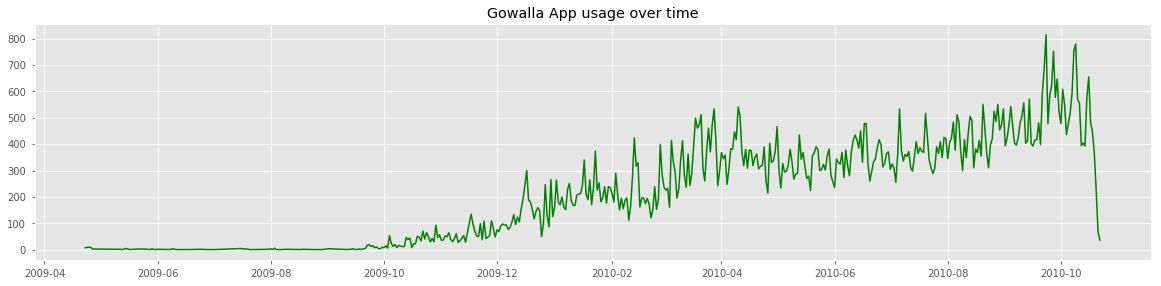

In [9]:
# Let us plot the events registered, ordered temporally by increasing timestamps and grouped by date
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.rcParams.update({'font.size': 12})
plt.rcParams['xtick.major.pad']='5'
plt.rcParams['ytick.major.pad']='5'
plt.style.use('ggplot')

plt.subplot(4, 1, 1)
top = nyc_events.groupby('date').size()
plt.plot(top.index, top, 'g-')
plt.title('Gowalla App usage over time')
plt.show()

What is the distribution of events per hour of the day, per day of the week, per day of the month?

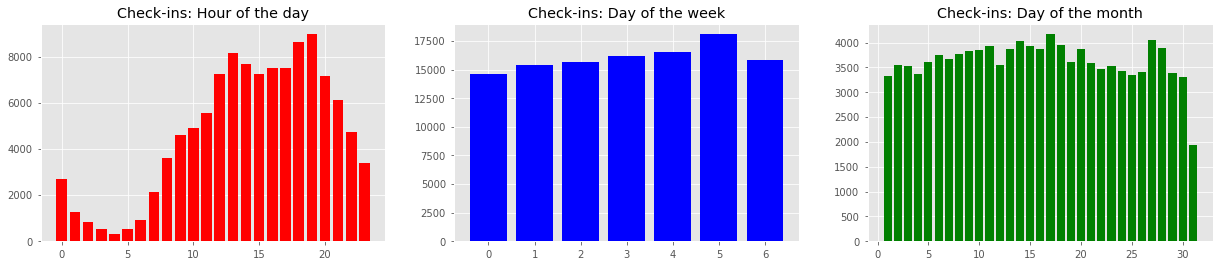

In [10]:
plt.style.use('ggplot')
fig = plt.figure()
fig.set_size_inches(21,4)

plt.subplot(1, 3, 1)
top = nyc_events.groupby('hour').size()
plt.bar(top.index, top,align='center', color='red')
plt.title('Check-ins: Hour of the day')

plt.subplot(1, 3, 2)
top = nyc_events.groupby('weekday').size()
plt.bar(top.index, top,align='center',color='blue')
plt.title('Check-ins: Day of the week')

plt.subplot(1, 3, 3)
top = nyc_events.groupby('day').size()
plt.bar(top.index, top,align='center',color='green')
plt.title('Check-ins: Day of the month')

plt.show()

Finding clusters in the NYC events data set

In [11]:
#for k in range(200, 270, 10):
    #kmeans = KMeans(n_clusters=k, init='k-means++')
    #X_sample = (nyc_events[['longitude','latitude']].sample(frac=0.1))
    #kmeans.fit(X_sample)
    #y = kmeans.labels_
    #print("k =", k, " silhouette_score ", silhouette_score(X_sample, y, metric='euclidean'))

# Rule of thumb for k: sqrt(n/2); here n is 112390 - total no. of NYC events
kmeans = KMeans(n_clusters=240, init='k-means++')

# Compute the clusters based on longitude and latitude features
X_sample = nyc_events[['longitude','latitude']].sample(frac=0.1)
kmeans.fit(X_sample)
y = kmeans.labels_
print("k = 240", " silhouette_score ", silhouette_score(X_sample, y, metric='euclidean'))

k = 240  silhouette_score  0.471607300065


Predicting and associating clusters for all the events in NYC

In [12]:
nyc_events['cluster'] = kmeans.predict(nyc_events[['longitude','latitude']])
nyc_events[['userid','latitude','longitude','spotid','cluster']].sample(10)

,userid,latitude,longitude,spotid,cluster
36179,35191,40.736812,-73.989476,78865,62
90729,15491,40.719694,-74.005851,59030,100
94458,118025,40.734540,-74.000649,1009608,175
67975,1810,40.771101,-73.985281,448256,58
82179,4604,40.744687,-73.977385,220590,97
73933,1940,40.756061,-73.966859,1110705,128
68585,39961,40.715605,-73.938282,200633,75
74081,123377,40.808588,-73.962536,422205,105
55287,1594,40.768085,-73.981240,314835,229
44201,5862,40.738429,-73.991355,99299,212


Top Visited Venues based on Count

In [13]:
gdf = nyc_events.groupby(['cluster', 'spotid']).size().reset_index()
gdf.columns = ['cluster', 'spotid', 'count']
idx = gdf.groupby(['cluster'])['count'].transform(max) == gdf['count']
topvenues_df = gdf[idx].merge(venues, on='spotid', how='left').sort_values(by='count', ascending=False)
#top 10 out of 200 clusters by events count
topvenues = topvenues_df[:10]

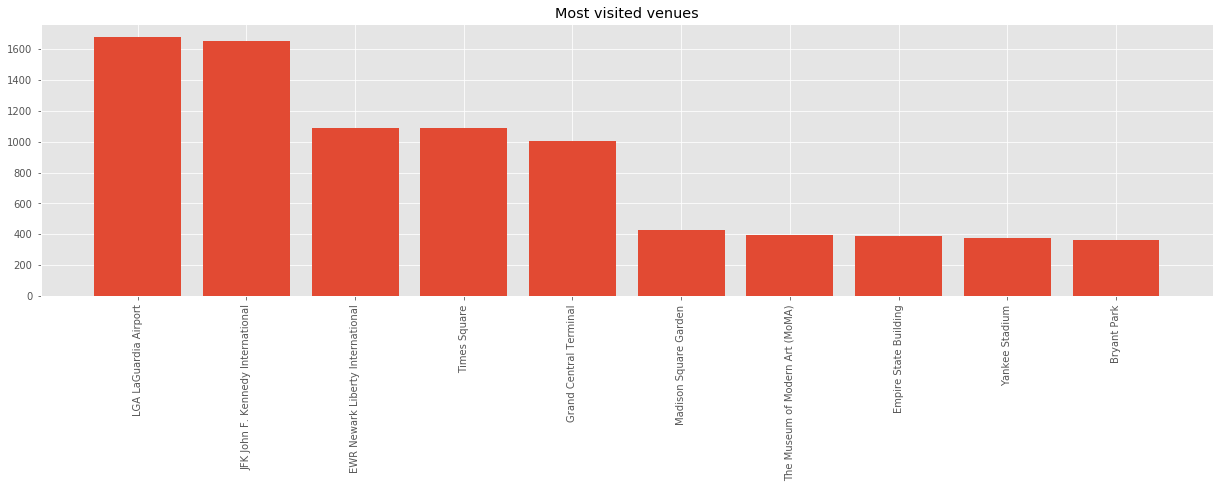

In [14]:
# Most Visited Venues
plt.style.use('ggplot')
fig = plt.figure()
fig.set_size_inches(21,5)

plt.bar(range(len(topvenues)), topvenues['count'], align='center')
plt.xticks(range(len(topvenues)),topvenues['spotname'], rotation='vertical')
plt.title('Most visited venues')
plt.show()

In [15]:
def recommend_venues(df, longitude, latitude):
    predicted_cluster = kmeans.predict(np.array([longitude,latitude]).reshape(1,-1))[0]
    # Fetch the venue name of the top most record in the topvenues dataframe for the predicted cluster
    venue_name = df[df['cluster']==predicted_cluster].iloc[0]['spotname']
    msg = 'What about visiting the ' + venue_name + '?'
    return msg

Make predictions

In [16]:
recommend_venues(topvenues_df, -74, 40.55)

'What about visiting the Coney Island Boardwalk?'

In [17]:
recommend_venues(topvenues_df, -73.993, 40.75)

'What about visiting the Madison Square Garden?'